<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/lung/glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification of Human Lung Cancer Cell lines using Metabolomics**

## **Introduction**

Lung cancer is broadly classified into two primary types: small cell lung cancer (SCLC) and non-small cell lung cancer (NSCLC).

SCLC typically originates in the bronchi, proliferating rapidly and quickly metastasizing to areas like the lymph nodes. It accounts for less than 20% of lung cancer cases and is strongly associated with tobacco smoking. SCLC is highly aggressive and frequently metastasizes, with only about a quarter of patients achieving remission.

NSCLC constitutes 80-90% of lung cancer diagnoses and tends to progress more slowly. Often asymptomatic in the early stages, NSCLC develops gradually, leading to delayed detection; approximately 75% of cases are diagnosed at advanced stages. Surgery is a viable option for early-stage patients, while those in later stages typically undergo chemotherapy and radiation therapy.

In this study, I compare the metabolomic profiles of SCLC and NSCLC using data from the DepMap Portal (depmap.org). The dataset includes 120 NSCLC and 50 SCLC cell lines, comprising a total of 225 metabolites (features). The analysis demonstrates the strong classification ability of these features, achieving f1 scores of 0.96 and 0.90 for NSCLC and SCLC, respectively, when using Logistic Regression. Combining Logistic Regression with Random Forest or using a Neural Network did not improve the f1 scores.

This work highlights the distinct metabolomic profiles of SCLC and NSCLC. Further research is needed to determine whether these differences play critical roles in the mechanisms of these diseases.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(42)

## **Load Data and Preprocess Data**

In [14]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
import fileinput
filePath ="/content/gdrive/MyDrive/lung/ds_whole.csv"

In [16]:
import pandas as pd
data = pd.read_csv(filePath)

In [17]:
data.head(3)

,RL,glaucoma,age,ocular_pressure,MD,PSD,GHT,cornea_thickness,RNFL4.mean
0,OD,0,62,17,-0.54,1.81,0,558,103.333333
1,OS,0,62,17,-0.64,1.38,0,564,107.666667
2,OD,0,66,12,-1.65,2.89,2,490,162.000000


In [18]:
data['glaucoma'].value_counts()

glaucoma
1    297
0    202
Name: count, dtype: int64

In [19]:
# RL:  "OD" and "OS" refer to the right and left eyes, respectively
columns_to_remove = ['RL']
data = data.drop(columns=columns_to_remove)

In [20]:
data.head(2)

,glaucoma,age,ocular_pressure,MD,PSD,GHT,cornea_thickness,RNFL4.mean
0,0,62,17,-0.54,1.81,0,558,103.333333
1,0,62,17,-0.64,1.38,0,564,107.666667


In [21]:
data.isnull().sum(axis=0)


glaucoma            0
age                 0
ocular_pressure     0
MD                  0
PSD                 0
GHT                 0
cornea_thickness    0
RNFL4.mean          0
dtype: int64

In [22]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

In [23]:
X.shape

(499, 7)

## **Clustering by KMeans**

To assess if the current features are sufficient allow the segregation of clusters (gluacoma vs normal), I perform cluster analysis using KMeans.

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

inertias_1 = []
silhouette_avgs = []
max_K = 5
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

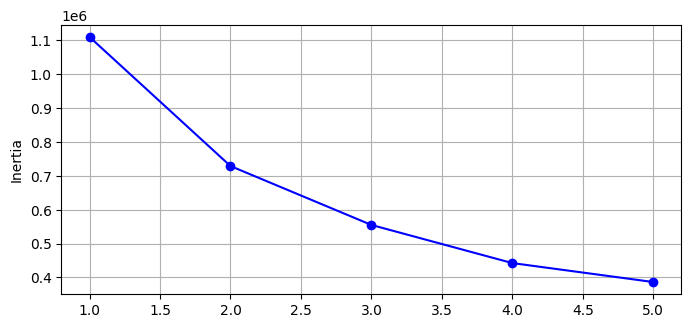

In [25]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 6), inertias_1, "bo-")
plt.xlabel("")
plt.ylabel("Inertia")
plt.grid()
plt.show()

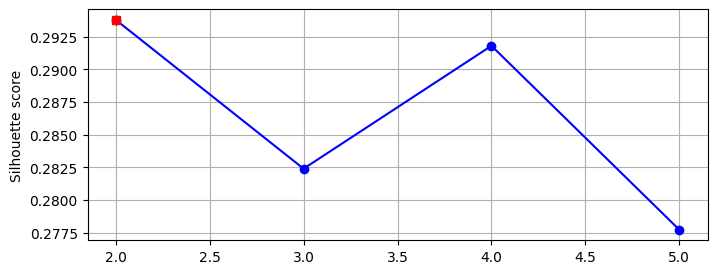

In [26]:
plt.figure(figsize=(8, 3))

k_range = range(2, 6)
best_index = np.argmax(silhouette_avgs)
best_k = k_range[best_index]
best_score = silhouette_avgs[best_index]

plt.plot(k_range, silhouette_avgs, "bo-")
plt.xlabel("")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

The optimial cluster is clusters based on Silhouette Score.

In [27]:
# using 2 clusters using all of the data
kmeans = KMeans(n_clusters=2, random_state=42).fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
cluster_labels = kmeans.labels_

# Initialize dictionaries to store indices of data points belonging to each cluster
cluster_indices = {}
for i in range(2):  # Assuming 2 clusters
    cluster_indices[i] = []

for i, label in enumerate(cluster_labels):
    cluster_indices[label].append(y[i])


In [30]:
from collections import Counter

for key, value in cluster_indices.items():
    freq = Counter(value)
    print(key, ':', freq)


0 : Counter({0: 152, 1: 123})
1 : Counter({1: 174, 0: 50})


In [31]:
# using PCA to visualize the two clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
labels = kmeans.labels_

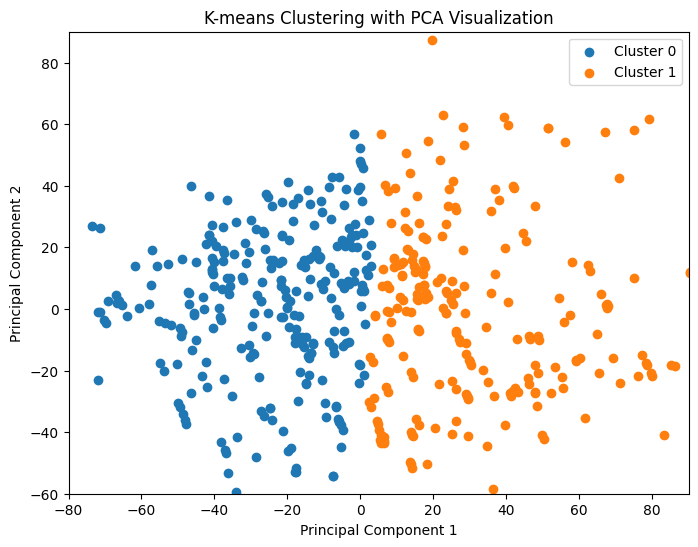

In [35]:

plt.figure(figsize=(8, 6))
x_range = (-80, 90)
y_range = (-60, 90)

for cluster_label in np.unique(labels):
    plt.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], label=f'Cluster {cluster_label}')

plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend()
plt.show()

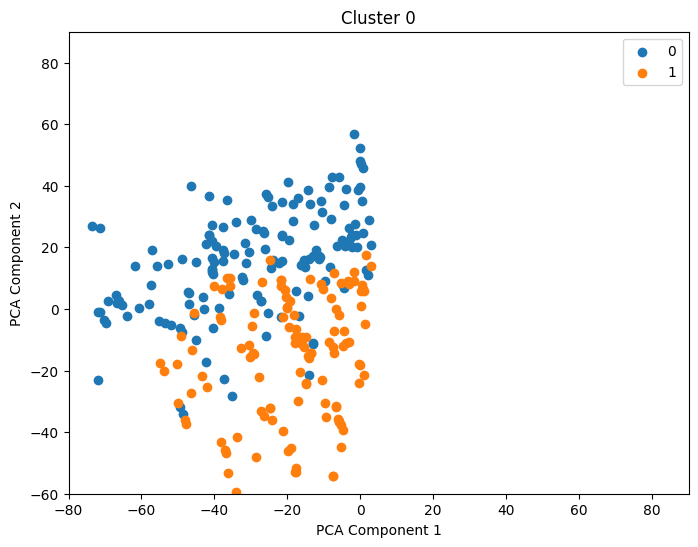

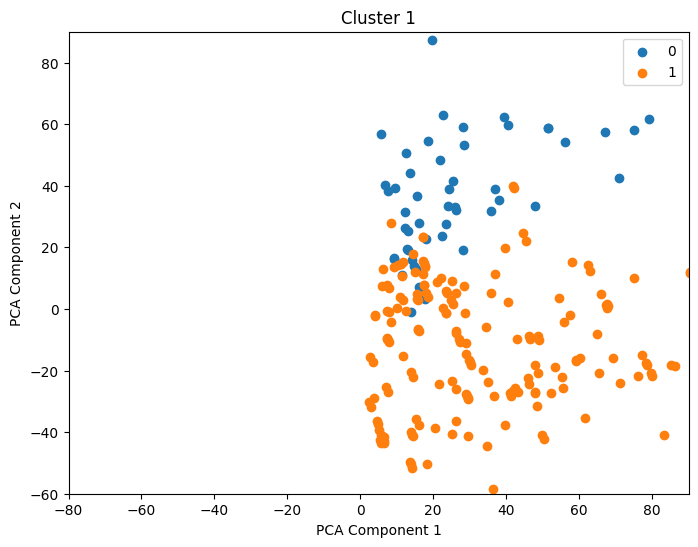

In [37]:
x_range = (-80, 90)
y_range = (-60, 90)

unique_labels = np.unique(kmeans.labels_)

for label in unique_labels:
    plt.figure(figsize=(8, 6))
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Cluster {label}')

    indices = np.where(kmeans.labels_ == label)

    for class_label in np.unique(data['glaucoma']):
        class_indices = np.where(data['glaucoma'].values[indices] == class_label)
        plt.scatter(X_pca[indices][class_indices, 0], X_pca[indices][class_indices, 1], label=f'{class_label}')
        print()

    plt.legend()
    plt.show()


Conclusion: Using KMean Clustering, there are optimually 2 clusters as assess by the Silhouette Score. Both Clusters compromise a mixture of glaucoma and non-glaucoma samples.

## **Classification**

I will use three difference approaches to try to classify Lung Cancer Cells with the aforementioned features. I will compare performance of Logistic Regression, SVC, and RandomForest Classifier. For each approach, I will determine the optimal parameters by grid_search.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Columns: 226 entries, 2-aminoadipate to lineage
dtypes: float64(225), object(1)
memory usage: 300.3+ KB


In [ ]:
# Check if any cell contains NaN
any_nan = data.isna().any().any()
any_nan

False

In [ ]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight

cv = 5

## **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

log_reg = LogisticRegression(class_weight=dict(zip(np.unique(y_train), class_weights)), max_iter=5000)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.05, 0.1],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={'Non-Small Cell': 0.7083333333333334,
                                                        'Small Cell': 1.7},
                                          max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.05, 0.1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
log_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(log_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'C': 0.05, 'penalty': 'l2', 'solver': 'saga'}
Mean Cross-Validation Score: 0.8685185185185185


In [ ]:
y_pred = log_best_model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[23,  1],
       [ 1,  9]])

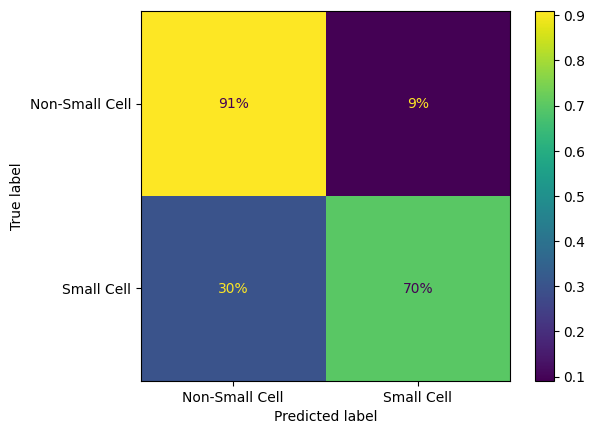

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Small Cell       0.96      0.96      0.96        24
    Small Cell       0.90      0.90      0.90        10

      accuracy                           0.94        34
     macro avg       0.93      0.93      0.93        34
  weighted avg       0.94      0.94      0.94        34



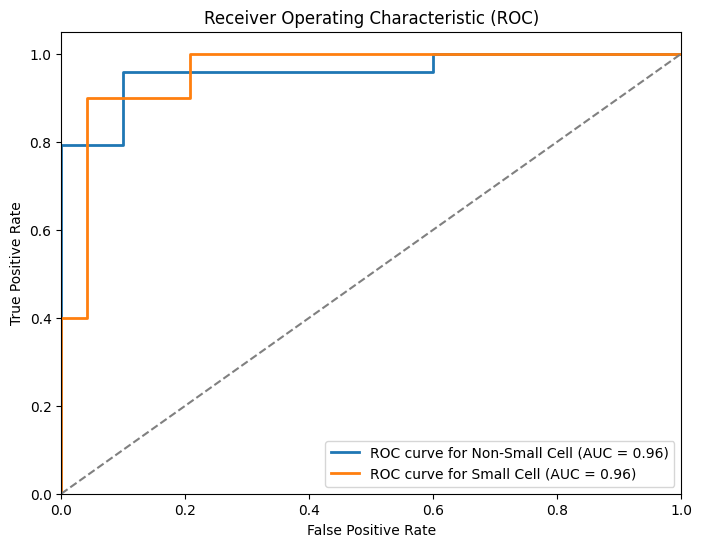

In [ ]:
from sklearn.metrics import roc_curve, auc

## auc
y_prob = log_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


## **SVC**

In [ ]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
}

grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

svc_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(svc_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'C': 1, 'gamma': 0.001}
Mean Cross-Validation Score: 0.875925925925926


In [ ]:
y_pred = svc_best_model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[22,  2],
       [ 1,  9]])

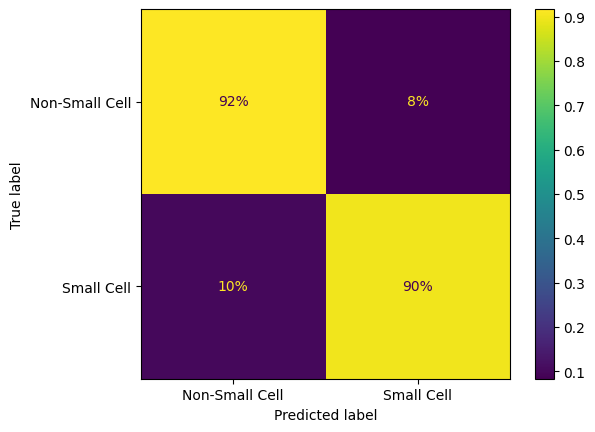

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [ ]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Small Cell       0.96      0.92      0.94        24
    Small Cell       0.82      0.90      0.86        10

      accuracy                           0.91        34
     macro avg       0.89      0.91      0.90        34
  weighted avg       0.92      0.91      0.91        34



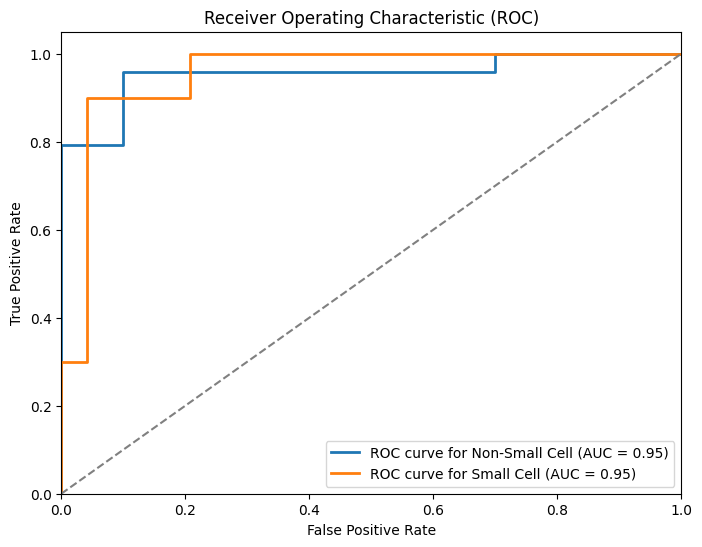

In [ ]:
## auc

y_prob = svc_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## **RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [300, 500, 800],  # Number of trees in the forest
    'max_depth': [None, 10, 20],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4, 8],     # Minimum number of samples required at each leaf node
}

# Perform grid search cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300, 500, 800]},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

rf_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(rf_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 800}
Mean Cross-Validation Score: 0.860846560846561


In [ ]:
y_pred = rf_best_model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[21,  3],
       [ 4,  6]])

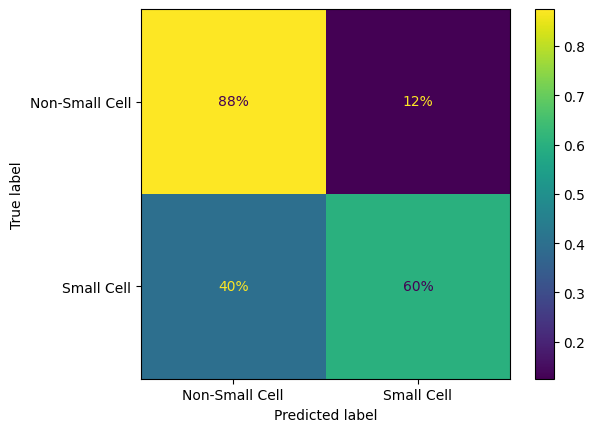

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Small Cell       0.84      0.88      0.86        24
    Small Cell       0.67      0.60      0.63        10

      accuracy                           0.79        34
     macro avg       0.75      0.74      0.74        34
  weighted avg       0.79      0.79      0.79        34



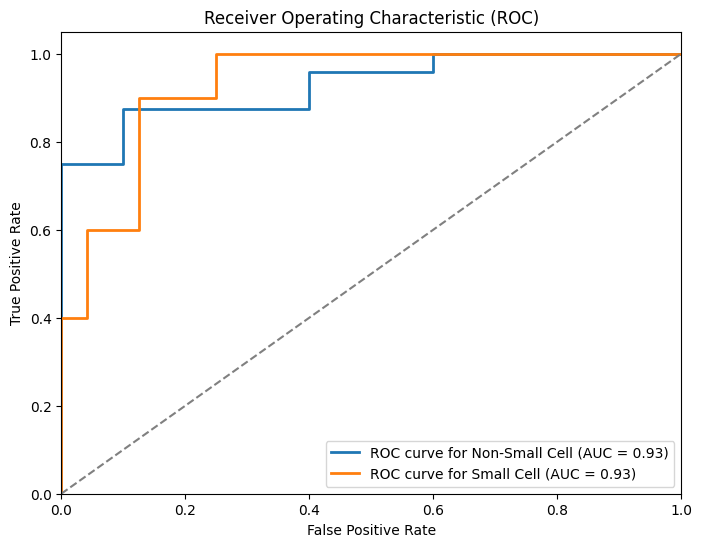

In [ ]:
## auc

y_prob = rf_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

I chose three different approaches, Logistic Regression, RandomForest, and SVC.,the best approach seems to be Logistic Regression, with F1 score for Non-Small Cell and Small Cell 0.96 and 0.90, respectively.

I use Voting Classifier to see if performance can be improved.

## Voting Classifier

In [ ]:
from sklearn.base import clone

log_model = LogisticRegression(class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('lr', log_model), ('rf', rf_model)], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[23,  1],
       [ 1,  9]])

In [ ]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

Non-Small Cell       0.96      0.96      0.96        24
    Small Cell       0.90      0.90      0.90        10

      accuracy                           0.94        34
     macro avg       0.93      0.93      0.93        34
  weighted avg       0.94      0.94      0.94        34



Using Voting Classifier marginally improve classification performance.

## **Analysis of Predictive Features**

Next, I perform deeper analysis of feature that are important for segregating the two classes of Lung Cancer Cells. First I ask how many features accounts for 90% of the prediction using the Logistic regression Model.

In [ ]:
# Get top coefficients of the logisitic model
coefficients = log_best_model.coef_[0]
top_10_indices = sorted(range(len(coefficients)), key=lambda i: abs(coefficients[i]), reverse=True)[:10]

top_10_features = [data.columns[i] for i in top_10_indices]

print("Top 10 features:")
print()
for feature in top_10_features:
    print(feature)

Top 10 features:

2-deoxycytidine
glutamate
uridine
cystathionine
glycine
6-phosphogluconate
C14:0 LPC
C34:1 PC
inositol
F1P/F6P/G1P/G6P


In [ ]:
# How many features accounts for 90% of prediction?

abs_coefficients = sorted(abs(coefficients), reverse=True)

# Calculate the cumulative importance
total_importance = sum(abs_coefficients)
cumulative_importance = 0
num_features = 0

for importance in abs_coefficients:
    cumulative_importance += importance
    num_features += 1
    if cumulative_importance >= 0.9 * total_importance:
        break

print(f"Of the 225 features, number of features accounting for 90% of the prediction: {num_features}")


Of the 225 features, number of features accounting for 90% of the prediction: 139


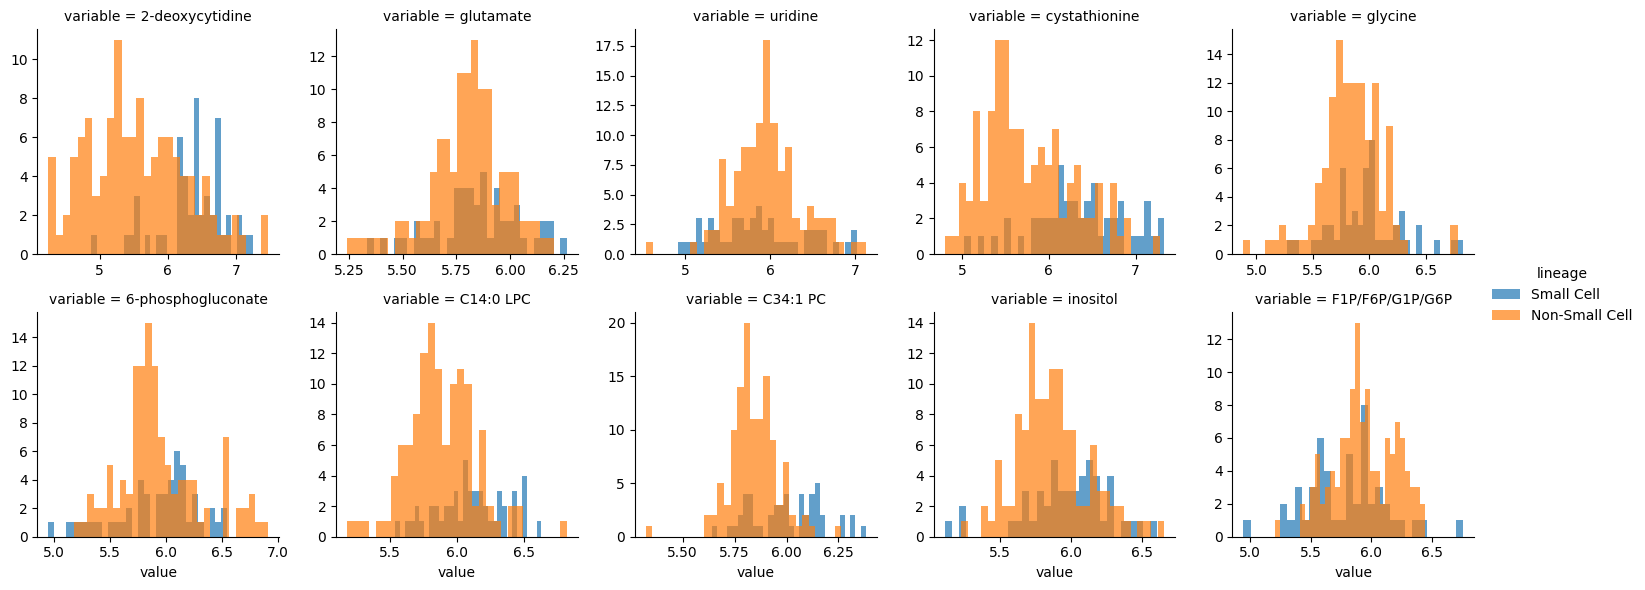

In [ ]:
import seaborn as sns

# Select top 10 features
top_10_indices = sorted(range(len(coefficients)), key=lambda i: abs(coefficients[i]), reverse=True)[:10]
top_10_features = [data.columns[i] for i in top_10_indices]

data_melted = pd.melt(data, id_vars='lineage', value_vars=top_10_features)

# Plot histograms using FacetGrid
g = sns.FacetGrid(data_melted, col='variable', hue='lineage', col_wrap=5, sharex=False, sharey=False)
g.map(plt.hist, 'value', bins=30, alpha=0.7)
g.add_legend()
plt.show()

Using the histogram for the top 10 features, the difference between Small Cell and Non-Small Cell Lung Cancer is often non-obvious. However, several metabolites, such as 2-Deoxycytidine and Cystathionine, are markedly higher in Small Cell Lung Cancer Cell lines.

## **Conclusion**

This work shows it is possible to classify Human Small Cell and Non-Small Cell Lung Cancer cells using metabolomic profiles. Interestingly, histogram of top 10 features show only small difference between these two types of cell lines. Further investigation needs to further elucidating these difference in metabolites play critical roles in tumor initition and pregression. This work, together with my previous work on the classification of Small Cell and Non-Small Cell Lung Cancer using miRNA expression [1] and Chromatin Profiles [2] highlight the distinct characteristic of these two Lung diseases.

[1] https://www.kaggle.com/code/gchan357/classification-of-human-lung-cancers

[2] https://www.kaggle.com/code/gchan357/lung-cancer-classification-chromatin-profiles

### Addendum

I explore if neural network classification will perform better than the approaches above.

In [ ]:
import sys
assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
y_train = y_train.apply(lambda x: 0 if x == "Non-Small Cell" else 1)
y_test = y_test.apply(lambda x: 0 if x == "Non-Small Cell" else 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [ ]:
X_train.shape

(136, 225)

In [ ]:
model = Sequential()

model.add(Dense(units=225,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=100,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=40,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=["accuracy"])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
model.fit(x=X_train,
          y=y_train,
          epochs=100,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
5/5 [==============================] - 2s 60ms/step - loss: 0.6489 - accuracy: 0.6985 - val_loss: 0.5953 - val_accuracy: 0.7059
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5920 - accuracy: 0.7059 - val_loss: 0.5963 - val_accuracy: 0.7059
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5838 - accuracy: 0.7059 - val_loss: 0.5524 - val_accuracy: 0.7059
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 0.5478 - accuracy: 0.7059 - val_loss: 0.5334 - val_accuracy: 0.7059
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 0.5208 - accuracy: 0.7132 - val_loss: 0.5219 - val_accuracy: 0.7059
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 0.5196 - accuracy: 0.7206 - val_loss: 0.4878 - val_accuracy: 0.7059
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.4842 - accuracy: 0.7132 - val_loss: 0.4702 - val_accuracy: 0.8529
Epoch 8/100
5/5 [===

<Axes: >

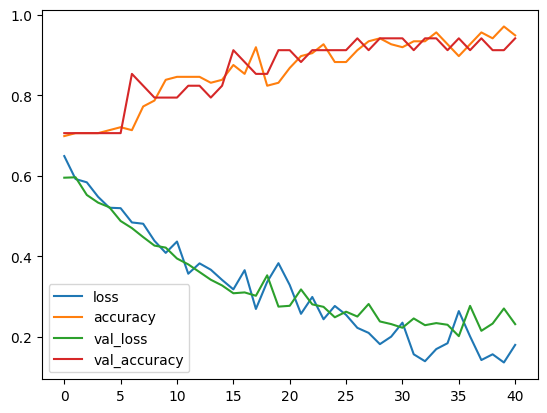

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

2/2 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.90      0.90      0.90        10

    accuracy                           0.94        34
   macro avg       0.93      0.93      0.93        34
weighted avg       0.94      0.94      0.94        34



Neural Network with the current configuration does not provide any improvement in classification performance compare to Logistic Regression.